In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set()
iris = sns.load_dataset('iris')
iris.head()

%matplotlib inline
mpl.rcParams['figure.figsize']=(10.0, 6)
mpl.rcParams['font.size']=14
mpl.rcParams['savefig.dpi']=90
mpl.rcParams['figure.subplot.bottom']=.1

In [2]:
from sklearn.datasets import load_digits
digits = load_digits()
images = digits.images
x_digits = images.reshape(images.shape[0], 64)
y_digits = digits.target

# Cross validation using hold-out sets

In [3]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

def print_mean_score(scores):
    print('Mean score: {}'.format(sum(scores) / len(scores)))

Let's start by using two hold out sets.

In [4]:
x_1, x_2, y_1, y_2 = train_test_split(x_digits, y_digits, train_size=0.5, random_state=10)
model = GaussianNB()
y_2_pred = model.fit(x_1, y_1).predict(x_2)
y_1_pred = model.fit(x_2, y_2).predict(x_1)

accuracy_1 = accuracy_score(y_2, y_2_pred)
accuracy_2 = accuracy_score(y_1, y_1_pred)
average_accuracy = (accuracy_1 + accuracy_2) / 2
print(accuracy_1, accuracy_2, average_accuracy)

0.823136818687 0.830734966592 0.82693589264


Now use N-fold cross validation using <b>`sklearn.cross_val_score`</b>

In [6]:
model = GaussianNB()
scores = cross_val_score(model, x_digits, y_digits, cv=5)
print_mean_score(scores)

Mean score: 0.8065207555552298


An extreme way to cross validate the dataset is by using all data points for training except one. i.e. If there size of the dataset is N then each training set would involve N-1 data points and the one left out would be used for testing.

In [69]:
from sklearn.model_selection import LeaveOneOut
scores = cross_val_score(model, x_digits, y_digits, cv=LeaveOneOut(), n_jobs=2)
print_mean_score(scores)

Mean score: 0.840845854201


*Warning - LeaveOneOut will be extremely expensive for large datasets.

### Using `KFold` cross validation.

In [80]:
from sklearn.model_selection import KFold
model = GaussianNB()
scores = cross_val_score(model, x_digits, y_digits, cv=KFold(20))
print_mean_score(scores)

Mean score: 0.828539325843


In [88]:
a = np.arange(10)
kf = KFold(5)
for x, y in list(kf.split(a)):
    print('x: {}, y: {}'.format(x, y))

x: [2 3 4 5 6 7 8 9], y: [0 1]
x: [0 1 4 5 6 7 8 9], y: [2 3]
x: [0 1 2 3 6 7 8 9], y: [4 5]
x: [0 1 2 3 4 5 8 9], y: [6 7]
x: [0 1 2 3 4 5 6 7], y: [8 9]


# Selecting the Best Model

In [123]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import validation_curve

def make_data(N, err=1.0, rseed=1):
    # randomly sample the data
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rng.randn(N)
    return X, y

def polynomial_regression(degree=2, **kwargs):
    return make_pipeline(
        PolynomialFeatures(degree=degree),
        LinearRegression(**kwargs)
    )

## Visualizing the predictions using models of varying polynomial degrees.

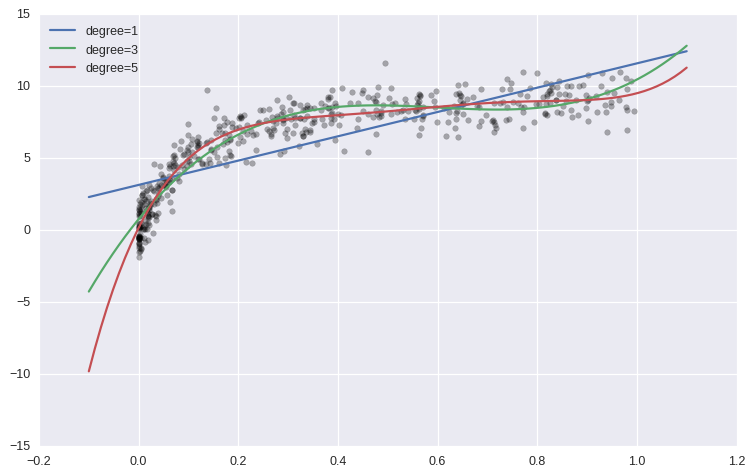

In [143]:
x, y = make_data(500)
x_test = np.linspace(-0.1, 1.1, 100)[:, None]
plt.scatter(x.ravel(), y, alpha=0.3, color='black')
for i in (1, 3, 5):
    y_test = polynomial_regression(degree=i).fit(x, y).predict(x_test)
    plt.plot(x_test.ravel(), y_test, label='degree={}'.format(i))
plt.legend(loc='best')

## Validation Curve

It is sometimes helpful to plot the influence of a single hyperparameter on the training score and the validation score to find out whether the estimator is overfitting or underfitting for some hyperparameter values.
The function validation_curve can help in this case

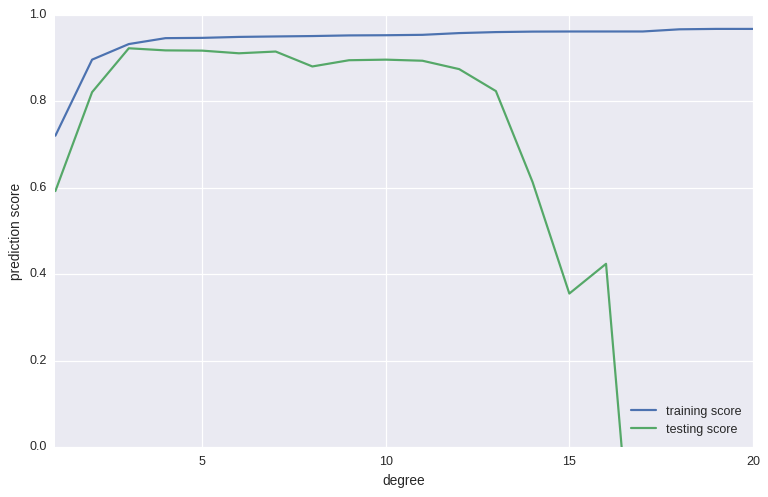

In [185]:
degrees = range(1, 21)
x, y = make_data(40)

train_scores, test_score = validation_curve(
    polynomial_regression(), 
    x, 
    y, 
    cv=7, 
    param_name='polynomialfeatures__degree', 
    param_range=degrees
)
plt.plot(degrees, np.median(train_scores, 1), label='training score')
plt.plot(degrees, np.median(test_score, 1), label='testing score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlim(1, 20)
plt.xlabel('degree')
plt.ylabel('prediction score')

From this validation curve it is evident that our model overfits (testing score negatively diverges from training score) as it's polynomial degree crosses a certain level i.e. 3. So for this dataset we conclude that a polynomial of degree 3 would make the optimal prediction.

> Another fact to note here is that complexity (degree of polynomial) depends the the size of training dataset. We will see that even a complex model won't overfit with a bigger dataset(200 vs 40).

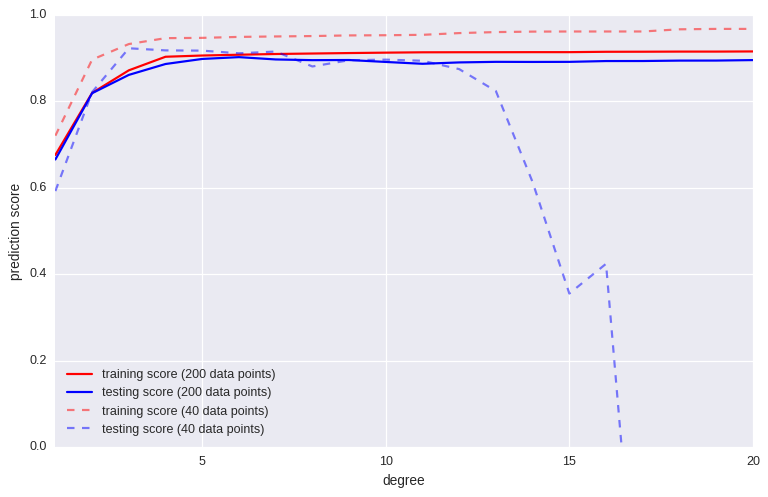

In [195]:
degrees = range(1, 21)
x, y = make_data(200)

train_scores_400, test_score_400 = validation_curve(
    polynomial_regression(), 
    x, 
    y, 
    cv=7, 
    param_name='polynomialfeatures__degree', 
    param_range=degrees
)
plt.plot(degrees, np.median(train_scores_400, 1), label='training score (200 data points)', color='r')
plt.plot(degrees, np.median(test_score_400, 1), label='testing score (200 data points)', color='b')
plt.plot(degrees, np.median(train_scores, 1), '--', label='training score (40 data points)', alpha=0.5, color='r')
plt.plot(degrees, np.median(test_score, 1), '--', label='testing score (40 data points)', alpha=0.5, color='b')

plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlim(1, 20)
plt.xlabel('degree')
plt.ylabel('prediction score')

## Learning curve
A learning curve shows the validation and training score of an estimator for varying numbers of training samples. It is a tool to find out how much we benefit from adding more training data and whether the estimator suffers more from a variance error or a bias error.

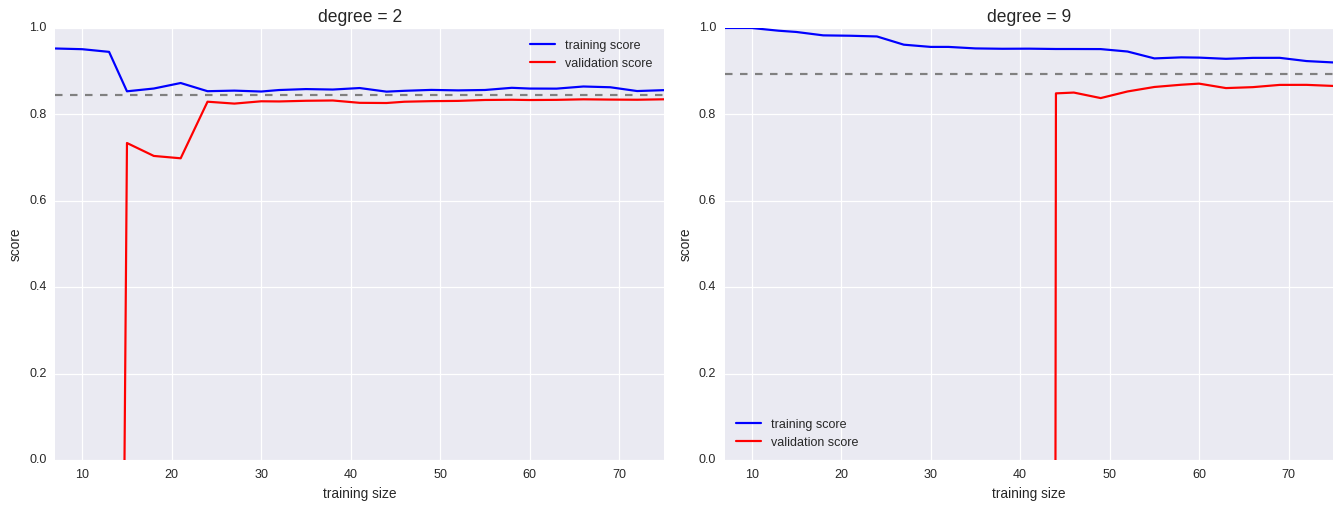

In [207]:
from sklearn.learning_curve import learning_curve
X, y = make_data(100)
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for i, degree in enumerate([2, 9]):
    N, train_lc, val_lc = learning_curve(polynomial_regression(degree),
                                         X, y, cv=4,
                                         train_sizes=np.linspace(0.1, 1, 25))

    ax[i].plot(N, np.mean(train_lc, 1), color='blue', label='training score')
    ax[i].plot(N, np.mean(val_lc, 1), color='red', label='validation score')
    ax[i].hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1],
                 color='gray', linestyle='dashed')

    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(N[0], N[-1])
    ax[i].set_xlabel('training size')
    ax[i].set_ylabel('score')
    ax[i].set_title('degree = {0}'.format(degree), size=14)
    ax[i].legend(loc='best')

This is a valuable diagnostic, because it gives us a visual depiction of how our model responds to increasing training data. In particular, when your learning curve has already converged (i.e., when the training and validation curves are already close to each other) adding more training data will not significantly improve the fit! This situation is seen in the left panel, with the learning curve for the degree-2 model.

The only way to increase the converged score is to use a different (usually more complicated) model. We see this in the right panel: by moving to a much more complicated model, we increase the score of convergence (indicated by the dashed line), but at the expense of higher model variance (indicated by the difference between the training and validation scores). If we were to add even more data points, the learning curve for the more complicated model would eventually converge.

## Validation in Practice: Grid Search

Plotting learning curves can be helpful while finding the optimal model. But practically speaking, the number of such hyper-parameters that affect the models can be so many that it can get hard to visualize. Grid search helps to choose the optimal model given a n-dimensional choice of hyper-parameters.

In [224]:
from sklearn.model_selection import GridSearchCV
x, y = make_data(40)
param_grid = {
    'polynomialfeatures__degree': np.arange(1, 21),
    'linearregression__fit_intercept': [True, False],
    'linearregression__normalize': [True, False]
}
grid = GridSearchCV(polynomial_regression(), param_grid, cv=7, n_jobs=2)
grid.fit(x, y)

GridSearchCV(cv=7, error_score='raise',
       estimator=Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))]),
       fit_params={}, iid=True, n_jobs=2,
       param_grid={'linearregression__normalize': [True, False], 'polynomialfeatures__degree': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20]), 'linearregression__fit_intercept': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [225]:
grid.best_params_

{'linearregression__fit_intercept': False,
 'linearregression__normalize': True,
 'polynomialfeatures__degree': 4}

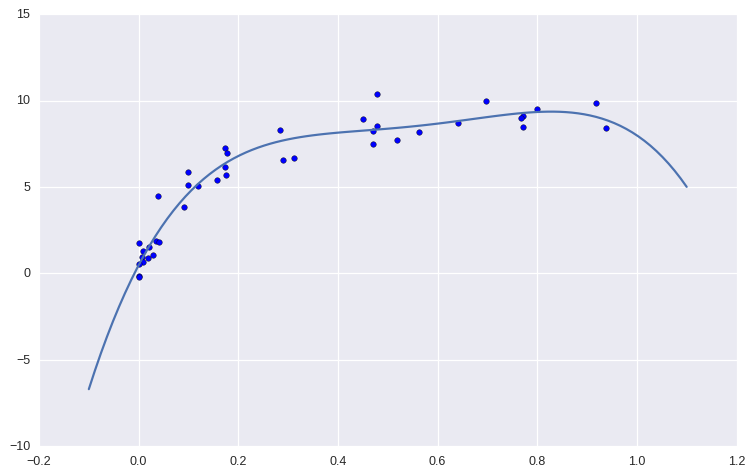

In [226]:
plt.scatter(x.ravel(), y)
y_predict = grid.best_estimator_.predict(x_test)
plt.plot(x_test.ravel(), y_predict)